In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy
import pathlib
import random
import torch
import torch.nn
import torch.nn.functional
import tqdm

In [2]:
# Defaults
DIR_READ = pathlib.Path(__name__).resolve().parent
DIR_OUT = pathlib.Path(__name__).resolve().parents[1] / "out" / "makemore-mlp"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
g = torch.Generator(device=device).manual_seed(2147483647) # default seed from the torch docs

In [3]:
# reading data to tokens
def load_txt_to_list(fname):
    path = pathlib.Path(fname)
    if not path.exists():
        raise f"{fname} not found!"

    list_out = []
    with open(path, "r") as file:
        list_out = file.read().splitlines()

    return list_out

def construct_map_token_to_index(list_tokens):
    """
    Returns { token : index }

    Map each token in the vocab to a unique integer,
    which will be its index into the Bag of words vector

    TODO: https://en.wikipedia.org/wiki/Feature_hashing
    NOTE: Fatal flaw is set sorting is random, making debugging a little harder
    """
    dict_to_ix = {}
    dict_to_word = {}
    for i, token in enumerate(set(list_tokens)):
        dict_to_ix[token] = i
        dict_to_word[i] = token

    return dict_to_ix, dict_to_word

fname = DIR_READ / "names.txt"
words = load_txt_to_list(fname)

dict_token_to_ix, dict_ix_to_token = construct_map_token_to_index("".join(words))

list_tokens_extra = ["."]
for token in list_tokens_extra:
    dict_token_to_ix[token] = len(dict_token_to_ix)
    dict_ix_to_token[len(dict_ix_to_token)] = token

In [4]:
# Calculating the ngrams
list_documents = [ list(string) + ["."] for string in words ] # different from before

def construct_vector_ngram(tokens_context, dict_index):
    return list(map(lambda w: dict_index[w], tokens_context))

def construct_n_grams(list_documents, dict_index, size_context, size_prediction=1):
    """
    Initialize an empty window
    Update as you go along

    NOTE: Creates size_context-1 more vectors to account for the stop tokens
    e.g., size_context = 3-1 creates
        [<S>, <S>, <T>]

    TODO: Account for when size_prediction is larger than length(document)
    """
    list_out = []
    vector = [dict_index["."]]*size_context
    for tokens in list_documents:
        # TODO: Right pad tokens to size_prediction
        for i in range(0, len(tokens)):
            vector = vector[size_prediction:] + construct_vector_ngram(tokens[i:i+size_prediction], dict_index)
            list_out.append(vector)
    return list_out

SIZE_CONTEXT = 4 # SIZE_NGRAMS+1 or BLOCKSIZE
list_vectors = construct_n_grams(list_documents, dict_token_to_ix, size_context=SIZE_CONTEXT)
# Verify the mapping
for document in list_documents[:3]:
    for i in range(len(document)): # num_ngrams
        print((["."]*(SIZE_CONTEXT-1) + document)[i:i+SIZE_CONTEXT], list_vectors[i])

matrix_ngrams = torch.tensor(list_vectors, dtype = torch.int64, device=device)

['.', '.', '.', 'e'] [26, 26, 26, 20]
['.', '.', 'e', 'm'] [26, 26, 20, 15]
['.', 'e', 'm', 'm'] [26, 20, 15, 15]
['e', 'm', 'm', 'a'] [20, 15, 15, 24]
['m', 'm', 'a', '.'] [15, 15, 24, 26]
['.', '.', '.', 'o'] [26, 26, 26, 20]
['.', '.', 'o', 'l'] [26, 26, 20, 15]
['.', 'o', 'l', 'i'] [26, 20, 15, 15]
['o', 'l', 'i', 'v'] [20, 15, 15, 24]
['l', 'i', 'v', 'i'] [15, 15, 24, 26]
['i', 'v', 'i', 'a'] [15, 24, 26, 16]
['v', 'i', 'a', '.'] [24, 26, 16, 11]
['.', '.', '.', 'a'] [26, 26, 26, 20]
['.', '.', 'a', 'v'] [26, 26, 20, 15]
['.', 'a', 'v', 'a'] [26, 20, 15, 15]
['a', 'v', 'a', '.'] [20, 15, 15, 24]


In [5]:
# Train/Test Split
random.seed(42)
random.shuffle(matrix_ngrams.clone())
xs = matrix_ngrams[:,0:SIZE_CONTEXT-1]
ys = matrix_ngrams[:,-1] # vector

n1 = int(0.8 * xs.shape[0])
n2 = int(0.9 * xs.shape[0])
Xtr, Xdev, Xts = xs.tensor_split((n1, n2), dim=0)
Ytr, Ydev, Yts = ys.tensor_split((n1, n2), dim=0)

In [6]:
def forward_pass(X, Y, list_parameters):
    """
    logits = tanh \circ (C[X] @ W1 + b1)) @ W2 + b2
    loss = cross_entropy(logits, Y)
    where 
        X is the tokenized inputs, Y is the tokenized outputs
        C is the (|V|, k) mapping that embeds X into a lower dimensional space
        W1 is the (k, hidden) weight matrix
        b1 is the (hidden, 1) bias vector
        W2 is the (hidden, |V|) weight matrix
        b2 = is the (|V|) bias vector
    
    i.e,
        logits = linear \circ tanh \circ linear \circ embedding
    """
    embed = list_parameters[0][X] # shape (num_ngrams[indices], SIZE_CONTEXT-1, SIZE_DIMENSION)
    h = torch.tanh(torch.einsum('ijk,jkl -> il', embed, list_parameters[1]) + list_parameters[2]) # hidden states
    logits = h @ list_parameters[3] + list_parameters[4]
    loss = torch.nn.functional.cross_entropy(logits, Y)

    return loss

# Exercise 2: Initialize Weights More Carefully
I was not careful with the intialization of the network in this video. The tensors were mistakenly initialized using randn, which samples from a standard normal distribution. 

(1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? 

(2) Can you tune the initialization to get a starting loss that is much more similar to (1)? HINT: Initialization (only?) matters on the final layer.

In [7]:
# Same as in the video - before hypertuning to just demonstrate
SIZE_DIMENSION=2
SIZE_HIDDEN=100
NUM_EPOCHS=2000
SIZE_BATCH=32

## Setting a baseline

This exercise's point is to demonstate initializing our weights appropriately with some extra thought can "speed up convergence and eliminate 'hockey stick' loss curves where in the first few iteration your network is basically just learning the bias."

	Loss before learning rate decay: 2.6849172115325928
	Loss after learning rate decay: 2.5449421405792236


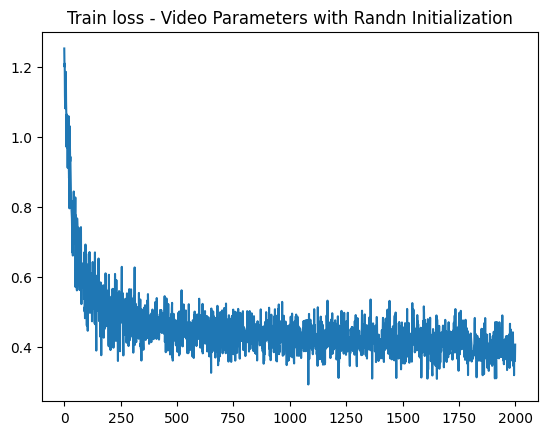

In [8]:
# Demo - Wasted epochs due to wrong initialization

C = torch.randn(size=(len(dict_ix_to_token),SIZE_DIMENSION), generator=g, device=device)
W1 = torch.randn(size=(SIZE_CONTEXT-1, SIZE_DIMENSION, SIZE_HIDDEN), generator=g, device=device)
b1 = torch.randn(SIZE_HIDDEN, generator=g, device=device)
W2 = torch.randn(size=(SIZE_HIDDEN, len(dict_ix_to_token)), generator=g, device=device)
b2 = torch.randn(len(dict_ix_to_token), generator=g, device=device)
list_parameters = [C, W1, b1, W2, b2]

list_steps = []
list_loss = []

LEARNING_RATE = 0.1 # discovered empirocally
epoch_decay = NUM_EPOCHS*0.9 # after 90% of epochs
for p in list_parameters:
    p.requires_grad=True
for i in range(NUM_EPOCHS):
    # mini-batch
    indices = torch.randint(0, Xtr.shape[0], (SIZE_BATCH,))
    loss = forward_pass(Xtr[indices], Ytr[indices], list_parameters)
    # backward pass
    for p in list_parameters:
        p.grad = None
    loss.backward()

    # update parameters
    if i == epoch_decay:
        print("\tLoss before learning rate decay:", loss.item())
        LEARNING_RATE = LEARNING_RATE * 0.1
    for p in list_parameters:
        p.data += -LEARNING_RATE * p.grad # going against the gradient reduces the loss
    list_steps.append(i)
    list_loss.append(loss.log10().item())

print("\tLoss after learning rate decay:", loss.item())
plt.title(f"Train loss - Video Parameters with Randn Initialization")
plt.plot(list_steps, list_loss)
plt.show()
plt.close()

## (1) Weight initialization via uniform distribution
This amounts to using rand vs randn. Let's see how quickly that reduces the hockey stick.

	Loss before learning rate decay: 2.6115269660949707
	Loss after learning rate decay: 2.801168441772461


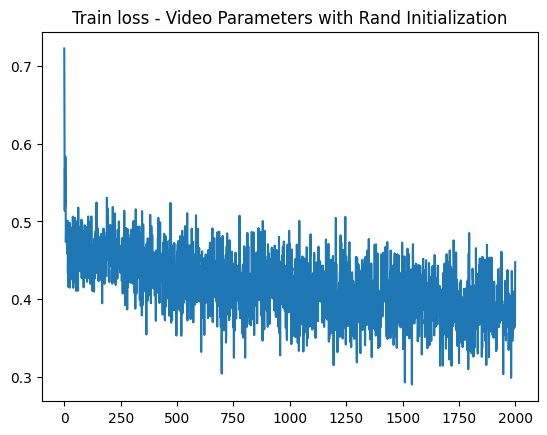

In [9]:
# Same as in the video - before hypertuning to just demonstrate
SIZE_DIMENSION=2
SIZE_HIDDEN=100
NUM_EPOCHS=2000
SIZE_BATCH=32

C = torch.rand(size=(len(dict_ix_to_token),SIZE_DIMENSION), generator=g, device=device)
W1 = torch.rand(size=(SIZE_CONTEXT-1, SIZE_DIMENSION, SIZE_HIDDEN), generator=g, device=device)
b1 = torch.rand(SIZE_HIDDEN, generator=g, device=device)
W2 = torch.rand(size=(SIZE_HIDDEN, len(dict_ix_to_token)), generator=g, device=device)
b2 = torch.rand(len(dict_ix_to_token), generator=g, device=device)
list_parameters = [C, W1, b1, W2, b2]

list_steps = []
list_loss = []

LEARNING_RATE = 0.1 # discovered empirocally
epoch_decay = NUM_EPOCHS*0.9 # after 90% of epochs
for p in list_parameters:
    p.requires_grad=True
for i in range(NUM_EPOCHS):
    # mini-batch
    indices = torch.randint(0, Xtr.shape[0], (SIZE_BATCH,))
    loss = forward_pass(Xtr[indices], Ytr[indices], list_parameters)
    # backward pass
    for p in list_parameters:
        p.grad = None
    loss.backward()

    # update parameters
    if i == epoch_decay:
        print("\tLoss before learning rate decay:", loss.item())
        LEARNING_RATE = LEARNING_RATE * 0.1
    for p in list_parameters:
        p.data += -LEARNING_RATE * p.grad # going against the gradient reduces the loss
    list_steps.append(i)
    list_loss.append(loss.log10().item())

print("\tLoss after learning rate decay:", loss.item())
plt.title(f"Train loss - Video Parameters with Rand Initialization")
plt.plot(list_steps, list_loss)
plt.show()
plt.close()

## (2) Tune initialization to the data

What if we intitialize the final layer weights according the distribution set by the data?

	Loss before learning rate decay: 2.4335031509399414
	Loss after learning rate decay: 2.39884877204895


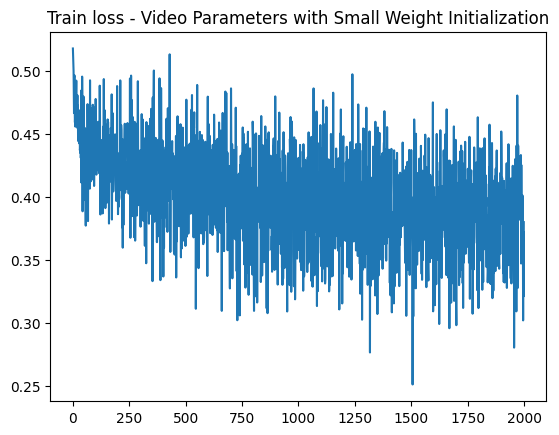

In [11]:
# Same as in the video - before hypertuning to just demonstrate
SIZE_DIMENSION=2
SIZE_HIDDEN=100
NUM_EPOCHS=2000
SIZE_BATCH=32

n_classes = len(dict_ix_to_token)
init_value = -numpy.log(1 / n_classes)

C = torch.randn(size=(len(dict_ix_to_token),SIZE_DIMENSION), generator=g, device=device)
W1 = torch.randn(size=(SIZE_CONTEXT-1, SIZE_DIMENSION, SIZE_HIDDEN), generator=g, device=device)
b1 = torch.randn(SIZE_HIDDEN, generator=g, device=device)
# Initialize weights and biases for final layer
W2 = torch.full(size=(SIZE_HIDDEN, n_classes),fill_value=init_value,device=device)
b2 = torch.zeros(n_classes, device=device)
list_parameters = [C, W1, b1, W2, b2]

list_steps = []
list_loss = []

LEARNING_RATE = 0.1 # discovered empirocally
epoch_decay = NUM_EPOCHS*0.9 # after 90% of epochs
for p in list_parameters:
    p.requires_grad=True
for i in range(NUM_EPOCHS):
    # mini-batch
    indices = torch.randint(0, Xtr.shape[0], (SIZE_BATCH,))
    loss = forward_pass(Xtr[indices], Ytr[indices], list_parameters)
    # backward pass
    for p in list_parameters:
        p.grad = None
    loss.backward()

    # update parameters
    if i == epoch_decay:
        print("\tLoss before learning rate decay:", loss.item())
        LEARNING_RATE = LEARNING_RATE * 0.1
    for p in list_parameters:
        p.data += -LEARNING_RATE * p.grad # going against the gradient reduces the loss
    list_steps.append(i)
    list_loss.append(loss.log10().item())

print("\tLoss after learning rate decay:", loss.item())
plt.title(f"Train loss - Video Parameters with Small Weight Initialization")
plt.plot(list_steps, list_loss)
plt.show()
plt.close()

# Exercise 1: Hyperparameter Search
Tune the hyperparameters of the training to beat my best validation loss of 2.2

Author's Note: I KNOW this can be done easier in pytorch & sklearn, but it's better to see how this works for educational reasons.

In [ ]:

def train_neural_net(xtr, ytr, list_parameters, num_epochs = 30000, size_batch = 35, tag = None):
    list_steps = []
    list_loss = []

    LEARNING_RATE = 0.1 # discovered empirocally
    epoch_decay = num_epochs*0.9 # after 90% of epochs
    for p in list_parameters:
        p.requires_grad=True
    for i in range(num_epochs):
        # mini-batch
        indices = torch.randint(0, xtr.shape[0], (size_batch,))
        loss = forward_pass(xtr[indices], ytr[indices], list_parameters)
        # backward pass
        for p in list_parameters:
            p.grad = None
        loss.backward()

        # update parameters
        if i == epoch_decay:
            print("\tLoss before learning rate decay:", loss.item())
            LEARNING_RATE = LEARNING_RATE * 0.1
        for p in list_parameters:
            p.data += -LEARNING_RATE * p.grad # going against the gradient reduces the loss
        list_steps.append(i)
        list_loss.append(loss.log10().item())

    print("\tLoss after learning rate decay:", loss.item())
    plt.title(f"Train log10-loss {tag}.png")
    plt.plot(list_steps, list_loss)
    plt.savefig(DIR_OUT / f"train-log10-loss-{sum(p.numel() for p in list_parameters)}-{tag}.png")
    plt.close()

    return list_parameters

In [ ]:
dict_hyperparameters = {
    "DIMENSIONS": [4,6,8,10,12],
    "HIDDENS": [100, 200, 300, 400, 500]
}
SIZE_BATCH = 128
BEST_PARAMETERS = None
BEST_LOSS = float('inf')
list_list_parameters = []
num_epochs = 10000
print("HYPERPARAMETER-TRAINING")
for (SIZE_DIMENSION, SIZE_HIDDEN) in tqdm.tqdm(list(itertools.product(*list(dict_hyperparameters.values())))):
    C = torch.rand(size=(len(dict_ix_to_token),SIZE_DIMENSION), generator=g, device=device)
    W1 = torch.rand(size=(SIZE_CONTEXT-1, SIZE_DIMENSION, SIZE_HIDDEN), generator=g, device=device)
    b1 = torch.rand(SIZE_HIDDEN, generator=g, device=device)
    W2 = torch.rand(size=(SIZE_HIDDEN, len(dict_ix_to_token)), generator=g, device=device)
    b2 = torch.rand(len(dict_ix_to_token), generator=g, device=device)
    list_parameters = [C, W1, b1, W2, b2]

    tag = (SIZE_DIMENSION, SIZE_HIDDEN)
    print(f"TRAINING NEURAL NET with (DIMENSION={SIZE_DIMENSION}, HIDDEN={SIZE_HIDDEN})")
    list_parameters_updated = train_neural_net(Xtr, Ytr, list_parameters, num_epochs, SIZE_BATCH, tag)
    loss_train = forward_pass(Xtr, Ytr, list_parameters_updated)
    loss_dev = forward_pass(Xdev, Ydev, list_parameters_updated)
    print("\tTraining loss:", loss_train.item())
    print("\tValidate loss:", loss_dev.item())
    if loss_dev.item() < BEST_LOSS:
        print(f"\tBest loss updated for (DIMENSION, HIDDEN): {SIZE_DIMENSION, SIZE_HIDDEN}")
        BEST_LOSS = loss_dev.item()
        BEST_PARAMETERS = (SIZE_DIMENSION, SIZE_HIDDEN)

print("\tBest loss",BEST_LOSS, "with (DIMENSION, HIDDEN)", BEST_PARAMETERS)

HYPERPARAMETER-TRAINING


  0%|          | 0/25 [00:00<?, ?it/s]

TRAINING NEURAL NET with (DIMENSION=4, HIDDEN=100)
	Loss before learning rate decay: 2.3964381217956543
	Loss after learning rate decay: 2.3666436672210693


  4%|▍         | 1/25 [00:49<19:48, 49.51s/it]

	Training loss: 2.322718620300293
	Validate loss: 2.542935371398926
	Best loss updated for (DIMENSION, HIDDEN): (4, 100)
TRAINING NEURAL NET with (DIMENSION=4, HIDDEN=200)
	Loss before learning rate decay: 2.39103102684021
	Loss after learning rate decay: 2.2972142696380615


  8%|▊         | 2/25 [01:30<17:03, 44.51s/it]

	Training loss: 2.3347537517547607
	Validate loss: 2.5405962467193604
	Best loss updated for (DIMENSION, HIDDEN): (4, 200)
TRAINING NEURAL NET with (DIMENSION=4, HIDDEN=300)
	Loss before learning rate decay: 2.336271047592163
	Loss after learning rate decay: 2.1987054347991943


 12%|█▏        | 3/25 [02:13<16:00, 43.67s/it]

	Training loss: 2.334138870239258
	Validate loss: 2.568892478942871
TRAINING NEURAL NET with (DIMENSION=4, HIDDEN=400)
	Loss before learning rate decay: 2.5457892417907715
	Loss after learning rate decay: 2.214876413345337


 16%|█▌        | 4/25 [03:00<15:44, 44.99s/it]

	Training loss: 2.3009350299835205
	Validate loss: 2.5354981422424316
	Best loss updated for (DIMENSION, HIDDEN): (4, 400)
TRAINING NEURAL NET with (DIMENSION=4, HIDDEN=500)
	Loss before learning rate decay: 2.8082199096679688
	Loss after learning rate decay: 2.416879177093506


 20%|██        | 5/25 [03:54<16:04, 48.22s/it]

	Training loss: 2.334836959838867
	Validate loss: 2.5623323917388916
TRAINING NEURAL NET with (DIMENSION=6, HIDDEN=100)
	Loss before learning rate decay: 2.4254281520843506
	Loss after learning rate decay: 2.33101224899292


 24%|██▍       | 6/25 [04:36<14:39, 46.28s/it]

	Training loss: 2.3125319480895996
	Validate loss: 2.532827854156494
	Best loss updated for (DIMENSION, HIDDEN): (6, 100)
TRAINING NEURAL NET with (DIMENSION=6, HIDDEN=200)
	Loss before learning rate decay: 2.2421605587005615
	Loss after learning rate decay: 2.231884002685547


 28%|██▊       | 7/25 [05:29<14:32, 48.49s/it]

	Training loss: 2.316272497177124
	Validate loss: 2.5506680011749268
TRAINING NEURAL NET with (DIMENSION=6, HIDDEN=300)
	Loss before learning rate decay: 2.4359896183013916
	Loss after learning rate decay: 2.237220525741577


 32%|███▏      | 8/25 [07:31<20:20, 71.82s/it]

	Training loss: 2.298750638961792
	Validate loss: 2.5589308738708496
TRAINING NEURAL NET with (DIMENSION=6, HIDDEN=400)
	Loss before learning rate decay: 2.676542043685913
	Loss after learning rate decay: 2.2643282413482666


 36%|███▌      | 9/25 [09:15<21:47, 81.73s/it]

	Training loss: 2.305476427078247
	Validate loss: 2.57936429977417
TRAINING NEURAL NET with (DIMENSION=6, HIDDEN=500)
	Loss before learning rate decay: 2.7118258476257324
	Loss after learning rate decay: 2.4553041458129883


 40%|████      | 10/25 [10:29<19:53, 79.56s/it]

	Training loss: 2.293982982635498
	Validate loss: 2.5545291900634766
TRAINING NEURAL NET with (DIMENSION=8, HIDDEN=100)
	Loss before learning rate decay: 2.175222873687744
	Loss after learning rate decay: 2.277735948562622


 44%|████▍     | 11/25 [11:10<15:45, 67.56s/it]

	Training loss: 2.2877840995788574
	Validate loss: 2.517744541168213
	Best loss updated for (DIMENSION, HIDDEN): (8, 100)
TRAINING NEURAL NET with (DIMENSION=8, HIDDEN=200)
	Loss before learning rate decay: 2.3705813884735107
	Loss after learning rate decay: 2.390019178390503


 48%|████▊     | 12/25 [12:37<15:58, 73.76s/it]

	Training loss: 2.295909881591797
	Validate loss: 2.5582034587860107
TRAINING NEURAL NET with (DIMENSION=8, HIDDEN=300)
	Loss before learning rate decay: 2.272771120071411
	Loss after learning rate decay: 2.2247745990753174


 52%|█████▏    | 13/25 [13:48<14:32, 72.74s/it]

	Training loss: 2.284935474395752
	Validate loss: 2.550629138946533
TRAINING NEURAL NET with (DIMENSION=8, HIDDEN=400)
	Loss before learning rate decay: 2.427489757537842
	Loss after learning rate decay: 2.2385025024414062


 56%|█████▌    | 14/25 [14:36<11:59, 65.39s/it]

	Training loss: 2.2648022174835205
	Validate loss: 2.5050528049468994
	Best loss updated for (DIMENSION, HIDDEN): (8, 400)
TRAINING NEURAL NET with (DIMENSION=8, HIDDEN=500)
	Loss before learning rate decay: 2.4847939014434814
	Loss after learning rate decay: 2.235915184020996


 60%|██████    | 15/25 [15:29<10:15, 61.54s/it]

	Training loss: 2.341719627380371
	Validate loss: 2.6820766925811768
TRAINING NEURAL NET with (DIMENSION=10, HIDDEN=100)
	Loss before learning rate decay: 2.2224602699279785
	Loss after learning rate decay: 2.0046744346618652


 64%|██████▍   | 16/25 [16:55<10:20, 68.92s/it]

	Training loss: 2.2699227333068848
	Validate loss: 2.5082297325134277
TRAINING NEURAL NET with (DIMENSION=10, HIDDEN=200)
	Loss before learning rate decay: 2.300025463104248
	Loss after learning rate decay: 2.40895938873291


 68%|██████▊   | 17/25 [18:10<09:25, 70.63s/it]

	Training loss: 2.2644553184509277
	Validate loss: 2.521078109741211
TRAINING NEURAL NET with (DIMENSION=10, HIDDEN=300)
	Loss before learning rate decay: 2.5672144889831543
	Loss after learning rate decay: 2.337656021118164


 72%|███████▏  | 18/25 [19:13<07:58, 68.39s/it]

	Training loss: 2.300452947616577
	Validate loss: 2.6176979541778564
TRAINING NEURAL NET with (DIMENSION=10, HIDDEN=400)
	Loss before learning rate decay: 2.3359336853027344
	Loss after learning rate decay: 2.273834705352783


 76%|███████▌  | 19/25 [20:18<06:45, 67.58s/it]

	Training loss: 2.288207530975342
	Validate loss: 2.6203348636627197
TRAINING NEURAL NET with (DIMENSION=10, HIDDEN=500)
	Loss before learning rate decay: 2.628025770187378
	Loss after learning rate decay: 2.117724895477295


 80%|████████  | 20/25 [21:43<06:03, 72.65s/it]

	Training loss: 2.2509899139404297
	Validate loss: 2.5061728954315186
TRAINING NEURAL NET with (DIMENSION=12, HIDDEN=100)
	Loss before learning rate decay: 2.37005352973938
	Loss after learning rate decay: 2.2300894260406494


 84%|████████▍ | 21/25 [23:02<04:58, 74.62s/it]

	Training loss: 2.2816789150238037
	Validate loss: 2.5426034927368164
TRAINING NEURAL NET with (DIMENSION=12, HIDDEN=200)
	Loss before learning rate decay: 2.4014499187469482
	Loss after learning rate decay: 2.1604673862457275


 88%|████████▊ | 22/25 [24:23<03:49, 76.59s/it]

	Training loss: 2.2337403297424316
	Validate loss: 2.4923994541168213
	Best loss updated for (DIMENSION, HIDDEN): (12, 200)
TRAINING NEURAL NET with (DIMENSION=12, HIDDEN=300)
	Loss before learning rate decay: 2.4785332679748535
	Loss after learning rate decay: 2.1955628395080566


 92%|█████████▏| 23/25 [25:56<02:43, 81.55s/it]

	Training loss: 2.2575223445892334
	Validate loss: 2.587883234024048
TRAINING NEURAL NET with (DIMENSION=12, HIDDEN=400)
	Loss before learning rate decay: 2.448808431625366
	Loss after learning rate decay: 2.54472017288208


 96%|█████████▌| 24/25 [27:11<01:19, 79.54s/it]

	Training loss: 2.2624053955078125
	Validate loss: 2.6233489513397217
TRAINING NEURAL NET with (DIMENSION=12, HIDDEN=500)
	Loss before learning rate decay: 2.697355031967163
	Loss after learning rate decay: 2.204313039779663


100%|██████████| 25/25 [28:11<00:00, 67.66s/it]

	Training loss: 2.2610063552856445
	Validate loss: 2.6454756259918213
	Best loss 2.4923994541168213 with (DIMENSION, HIDDEN) (12, 200)


# E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. 
Did it work?
